# Data cleaning and Reduction
#### Final datasets

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import astropy
from astropy.time import Time
from astropy.coordinates import EarthLocation, AltAz, get_body
import astropy.units as u
from augerscalerpy.scaler_cleaning import scaler_clean, plot_data
from augerscalerpy.plot_config import configure_plots

## Datos Pierre Auger

In [29]:
scaler300s = scaler_clean('scaler_datasets/scaler_300s_FINAL.csv')
scaler300s

,Date,ScalerCorr,errmean,arrvar,activeSD,pressure
0,2005-12-31 23:59:46,1604.310000,0.226024,1555.812279,584,857.586
1,2006-01-01 00:04:46,1659.087559,0.184573,1555.812279,555,857.690
2,2006-01-01 00:09:46,1604.690000,0.221103,1555.812279,548,857.790
3,2006-01-01 00:14:46,1604.730000,0.220782,1555.812279,545,857.893
4,2006-01-01 00:19:46,1602.570000,0.210147,1555.812279,551,857.995
...,...,...,...,...,...,...
1533050,2021-09-30 18:34:46,1665.460000,0.166624,1555.812279,544,856.860
1533051,2021-09-30 18:39:46,1665.100000,0.179557,1555.812279,549,856.860
1533052,2021-09-30 18:44:46,1666.210000,0.215630,1555.812279,542,856.815
1533053,2021-09-30 18:49:46,1661.490000,0.378396,1555.812279,287,856.770


In [3]:
### Aislando los datos de CRI
auger = scaler300s[['Date', 'ScalerCorr']]
auger = auger.rename(columns={'Date': 'date', 'ScalerCorr': 'auger'})
auger.set_index('date', inplace=True)
# Resample a un valor diario y calcula el promedio
auger = auger.resample('3H').mean()
# Reinicia el índice para que 'Date' vuelva a ser una columna
auger.reset_index(inplace=True)
auger['auger'] = auger['auger'].astype('float64')
columnas_numericas = auger.columns[auger.dtypes == 'float64']
promedios_df = auger[columnas_numericas].mean()
# Normalizar cada columna dividiendo por su promedio
auger[columnas_numericas] = auger[columnas_numericas] / promedios_df
auger

,date,auger
0,2005-12-31 21:00:00,0.967035
1,2006-01-01 00:00:00,0.968125
2,2006-01-01 03:00:00,0.971042
3,2006-01-01 06:00:00,0.976785
4,2006-01-01 09:00:00,0.982281
...,...,...
46011,2021-09-30 06:00:00,0.999954
46012,2021-09-30 09:00:00,1.002804
46013,2021-09-30 12:00:00,1.007522
46014,2021-09-30 15:00:00,1.004262


In [4]:
# ¿La serie de tiempo de los datos es continua?
import pandas as pd
# Ordena el DataFrame por la columna de tiempo.
scaler300s = scaler300s.sort_values(by=['Date'])
# Calcula la diferencia entre los valores de tiempo adyacentes.
time_diff = scaler300s['Date'].diff()
# Define un timedelta de 5 minutos (300 segundos).
five_minutes = pd.Timedelta(minutes=5)
# Verifica si la diferencia es aproximadamente igual a 5 minutos (300 segundos).
is_continuous = (time_diff == five_minutes)
# La variable 'is_continuous' contendrá valores True para filas con diferencias de 5 minutos
# y False para aquellas que no cumplan con esa condición.
# Puedes contar los valores True y False para verificar si los datos son continuos en el tiempo.
count_continuous = is_continuous.sum()
count_not_continuous = len(is_continuous) - count_continuous
print("Número de intervalos de 5 minutos:", count_continuous)
print("Número de intervalos que no son de 5 minutos:", count_not_continuous)

Número de intervalos de 5 minutos: 1532190
Número de intervalos que no son de 5 minutos: 865


## Datos de la estación Neutron Monitor - Olulu

In [5]:
CRIdf = pd.read_csv('solar_parameters/oulu.csv')
CRIdf['CorrectedCountRate[cts/min]'] = pd.to_numeric(CRIdf['CorrectedCountRate[cts/min]'], errors='coerce')
CRIdf['Timestamp'] = pd.to_datetime(CRIdf['Timestamp'])
CRIdf.set_index('Timestamp', inplace=True) # Convierto la columna Date en índices esto los preserva
CRIdf[CRIdf == 0] = None # Convierto los valores cero en NaN para que no afecten el promedio
CRIdf[CRIdf > 7000] = None # Convierto los EXCESOS en NaN para que no afecten el promedio
CRIdf[CRIdf < 4000] = None # Convierto los EXCESOS en NaN para que no afecten el promedio

In [6]:
mean_value = CRIdf['CorrectedCountRate[cts/min]'].mean()
CRIdf['CorrectedCountRate[cts/min]'].fillna(mean_value, inplace=True)
CRIdf.reset_index(inplace=True) # Vuelvo a convertir Date en una columna para poder trabajar con ella...
#threshold_above = 1.1 * mean_value  # % por encima del valor promedio
#threshold_below = 0.9 * mean_value  # % por debajo del valor promedio
#mask_above = CRIdf['CorrectedCountRate[cts/min]'] > threshold_above
#mask_below = CRIdf['CorrectedCountRate[cts/min]'] < threshold_below
#CRIdf.loc[mask_above, 'CorrectedCountRate[cts/min]'] = mean_value
#CRIdf.loc[mask_below, 'CorrectedCountRate[cts/min]'] = mean_value


In [7]:
oulu = CRIdf[['Timestamp', 'CorrectedCountRate[cts/min]']]
oulu = oulu.rename(columns={'Timestamp': 'date', 'CorrectedCountRate[cts/min]': 'oulu'})
oulu['oulu'] = oulu['oulu'].astype('float64')
columnas_numericas = oulu.columns[oulu.dtypes == 'float64']
promedios_df = oulu[columnas_numericas].mean()
# Normalizar cada columna dividiendo por su promedio
oulu[columnas_numericas] = oulu[columnas_numericas] / promedios_df
oulu

,date,oulu
0,1990-01-01 00:00:00+00:00,0.835339
1,1990-01-01 03:00:00+00:00,0.836135
2,1990-01-01 06:00:00+00:00,0.840431
3,1990-01-01 09:00:00+00:00,0.839158
4,1990-01-01 12:00:00+00:00,0.839635
...,...,...
93491,2021-12-30 09:00:00+00:00,1.064302
93492,2021-12-30 12:00:00+00:00,1.065415
93493,2021-12-30 15:00:00+00:00,1.060005
93494,2021-12-30 18:00:00+00:00,1.053164


## DATASETS DE LA NMDB:


In [8]:
def nmdb_clean(filename):
    skip_rows = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 22, 23]
    df = pd.read_csv(filename, delimiter=';', skiprows=skip_rows, header=None)
    df.columns = ['date', 'counts/s']
    df['date'] = pd.to_datetime(df['date'])
    df['counts/s'] = df['counts/s'].astype('float64')
    columnas_numericas = df.columns[df.dtypes == 'float64']
    promedios_df = df[columnas_numericas].mean()
    # Normalizar cada columna dividiendo por su promedio
    df[columnas_numericas] = df[columnas_numericas] / promedios_df
    column_name = "counts/s"
    # Calcula la media de la columna
    mean = df[column_name].mean()
    # Define un factor para determinar los valores que considerarás excesos
    threshold = 0.08  # 10% por fuera de la media
    # Reemplaza los valores que están por fuera del umbral por el valor medio
    df[column_name] = np.where(abs(df[column_name] - mean) > threshold * mean, mean, df[column_name])
    # Grafica el resultado
    #df.plot(kind='scatter', s=2, x='date', y='counts/s', figsize=(10, 5), color='black')
    print(len(df))
    return df

In [9]:
athenas = nmdb_clean('nm_data/long_files/athenas_NMDB.txt')
mexico = nmdb_clean('nm_data/long_files/mexico_NMDB.txt')
roma = nmdb_clean('nm_data/long_files/rome_NMDB.txt')
tsumeb = nmdb_clean('nm_data/long_files/tsumeb_NMDB.txt')

62228
92440
67423
75223


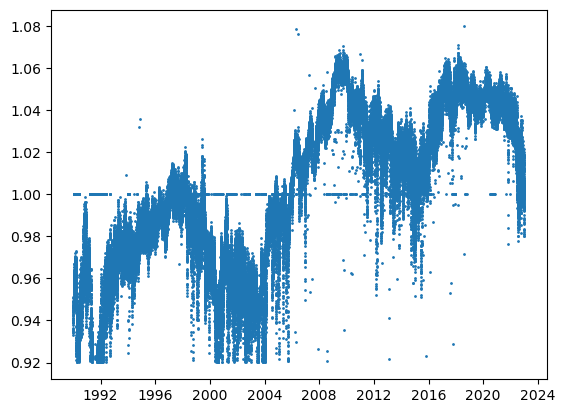

In [10]:
plt.scatter(mexico['date'],mexico['counts/s'],s=1)

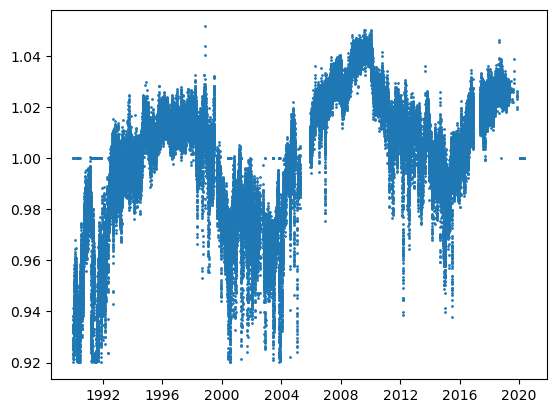

In [11]:
plt.scatter(tsumeb['date'],tsumeb['counts/s'],s=1)

## Creando un Dataset para todos los datos con resolución de 3h

In [12]:
import pandas as pd

# Supongamos que tienes 5 DataFrames llamados oulu, auger, athenas, roma y tsumeb
combined_df = oulu.copy()  # Inicializar el DataFrame combinado con oulu
dataframes = [(auger, "_2"), (mexico, "_3"), (athenas, "_4"), (roma, "_5"), (tsumeb, "_6")]

for df, suffix in dataframes:
    df['date'] = df['date'].dt.tz_localize(None).dt.tz_localize('UTC')
    # Combinar los DataFrames usando merge_asof
    combined_df = pd.merge_asof(combined_df, df, on="date", suffixes=("", suffix))

combined_df = combined_df.rename(columns={'counts/s': 'mexico', 'counts/s_4': 'athenas','counts/s_5': 'roma', 'counts/s_6': 'tsumeb'})

#combined_df.to_csv('CRI_auger_NM_3H.csv', index=False)
combined_df

,date,oulu,auger,mexico,athenas,roma,tsumeb
0,1990-01-01 00:00:00+00:00,0.835339,NaN,0.934069,NaN,NaN,NaN
1,1990-01-01 03:00:00+00:00,0.836135,NaN,0.936287,NaN,NaN,0.926468
2,1990-01-01 06:00:00+00:00,0.840431,NaN,0.934765,NaN,NaN,0.926723
3,1990-01-01 09:00:00+00:00,0.839158,NaN,0.933133,NaN,NaN,0.925214
4,1990-01-01 12:00:00+00:00,0.839635,NaN,0.937709,NaN,NaN,0.926668
...,...,...,...,...,...,...,...
93491,2021-12-30 09:00:00+00:00,1.064302,1.003458,1.037700,1.015503,1.0,1.000000
93492,2021-12-30 12:00:00+00:00,1.065415,1.003458,1.041967,1.015449,1.0,1.000000
93493,2021-12-30 15:00:00+00:00,1.060005,1.003458,1.041962,1.011533,1.0,1.000000
93494,2021-12-30 18:00:00+00:00,1.053164,1.003458,1.041494,1.009747,1.0,1.000000


## Histórico del número de manchas solares
#### Fuente: https://www.sidc.be/SILSO/datafiles

In [43]:
SSN = pd.read_csv('solar_parameters/SN_d_tot_V2.0.csv', delimiter=';')
SSN = SSN.rename(columns={'date': 'Año', 'xx': 'Mes','xx.1':'Dia'})
# Crea una nueva columna "FechaStr" con el formato correcto (YYYY-MM-DD)
SSN['FechaStr'] = SSN['Año'].astype(str) + '-' + SSN['Mes'].astype(str) + '-' + SSN['Dia'].astype(str)
# Convierte la columna "FechaStr" en formato datetime
SSN['date'] = pd.to_datetime(SSN['FechaStr'], errors='coerce')
# Eliminar la columna temporal "FechaStr"
del SSN['FechaStr']
del SSN['Año']
del SSN['Mes']
del SSN['Dia']
#del SSN['date']


SSN['sunspots'] = np.where(SSN['sunspots'] == -1.0, np.nan, SSN['sunspots']) #Convirtiendo excesos en NAN
avg_value = SSN['sunspots'].mean(skipna=True) #Calculando el promedio ignorando estos excesos
#SSN['sunspots'] = SSN['sunspots'].replace(0, np.nan) #Convirtiendo ceros en NAN
SSN['sunspots'] = np.where(SSN['sunspots'] > 50.0, avg_value, SSN['sunspots']) #Convirtiendo excesos en NAN
#SSN['sunspots'].fillna(avg_value, inplace=True) # Llenando los NAN por este valor promedio

# Ahora el DataFrame contiene una nueva columna "Fecha" en formato datetime
SN = SSN[['date', 'sunspots']]
SN

,date,sunspots
0,1818-01-01,NaN
1,1818-01-02,NaN
2,1818-01-03,NaN
3,1818-01-04,NaN
4,1818-01-05,NaN
...,...,...
75143,2023-09-26,17.2
75144,2023-09-27,18.3
75145,2023-09-28,9.4
75146,2023-09-29,9.0


In [15]:
type(SN['sunspots'])

pandas.core.series.Series

## Histórico del número de Viento Solar
#### Fuente: https://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/omni_m_daily.dat

In [44]:
SW = pd.read_csv('solar_parameters/omni_m_daily.dat', sep=r'\s+', engine='python')
SW['solarw'] = np.where(SW['solarw'] == 9999.0, np.nan, SW['solarw']) #Convirtiendo excesos en NAN
SW['solarw'] = SW['solarw'].replace(0, np.nan) #Convirtiendo ceros en NAN
avg_value = SW['solarw'].mean(skipna=True) #Calculando el promedio ignorando estos excesos

SW['solarw'].fillna(avg_value, inplace=True) # Llenando los NAN por este valor promedio

SW['date'] = pd.to_datetime(SW['year'].astype(str) + SW['day'].astype(str), format='%Y%j') #Estableciendo el formato de fecha datetime
SW = SW[['date', 'solarw']]
SW

,date,solarw
0,1963-01-01,435.232565
1,1963-01-02,435.232565
2,1963-01-03,435.232565
3,1963-01-04,435.232565
4,1963-01-05,435.232565
...,...,...
22275,2023-12-27,435.232565
22276,2023-12-28,435.232565
22277,2023-12-29,435.232565
22278,2023-12-30,435.232565


## Histórico del Pierre Auger desde 2006

In [31]:
scaler300s.set_index('Date', inplace=True)
# Resample a un valor diario y calcula el promedio
scaler_daily = scaler300s.resample('D').mean()

# Reinicia el índice para que 'Date' vuelva a ser una columna
scaler_daily.reset_index(inplace=True)
scaler_CRI = scaler_daily[['Date', 'ScalerCorr']]
scaler_CRI = scaler_CRI.rename(columns={'Date': 'date', 'ScalerCorr': 'CRI'})
scaler_CRI

,date,CRI
0,2005-12-31,1604.310000
1,2006-01-01,1621.421441
2,2006-01-02,1622.655297
3,2006-01-03,1624.644297
4,2006-01-04,1623.360478
...,...,...
5748,2021-09-26,1649.738681
5749,2021-09-27,1653.847222
5750,2021-09-28,1658.673021
5751,2021-09-29,1657.107569


In [45]:
scaler_CRI['date'] = pd.to_datetime(scaler_CRI['date']).dt.strftime('%Y-%m-%d')
SN['date'] = pd.to_datetime(SN['date']).dt.strftime('%Y-%m-%d')
SN = SN[['date', 'sunspots']]
SW['date'] = pd.to_datetime(SW['date']).dt.strftime('%Y-%m-%d')
SN

/tmp/ipykernel_5567/3897781618.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SN['date'] = pd.to_datetime(SN['date']).dt.strftime('%Y-%m-%d')


,date,sunspots
0,1818-01-01,NaN
1,1818-01-02,NaN
2,1818-01-03,NaN
3,1818-01-04,NaN
4,1818-01-05,NaN
...,...,...
75143,2023-09-26,17.2
75144,2023-09-27,18.3
75145,2023-09-28,9.4
75146,2023-09-29,9.0


In [46]:
# Lista de DataFrames a fusionar
dataframes = [SN, SW, scaler_CRI]  # Agrega todos tus DataFrames a esta lista

# Columna en común para fusionar
common_column = 'date'

# Inicializa el DataFrame combinado con el primero de la lista
auger_solar_parameter = dataframes[0]

# Fusiona los DataFrames usando pd.merge_asof
for df in dataframes[1:]:
    # Asegúrate de que la columna 'date' en df tenga el mismo formato
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    auger_solar_parameter['date'] = pd.to_datetime(auger_solar_parameter['date'], format='%Y-%m-%d')
    auger_solar_parameter = pd.merge_asof(auger_solar_parameter, df, on=common_column)

auger_solar_parameter.to_csv('auger_solar_parameter_1D.csv', index=False)
auger_solar_parameter

,date,sunspots,solarw,CRI
0,1818-01-01,NaN,NaN,NaN
1,1818-01-02,NaN,NaN,NaN
2,1818-01-03,NaN,NaN,NaN
3,1818-01-04,NaN,NaN,NaN
4,1818-01-05,NaN,NaN,NaN
...,...,...,...,...
75143,2023-09-26,17.2,462.0,1661.799868
75144,2023-09-27,18.3,455.0,1661.799868
75145,2023-09-28,9.4,394.0,1661.799868
75146,2023-09-29,9.0,431.0,1661.799868


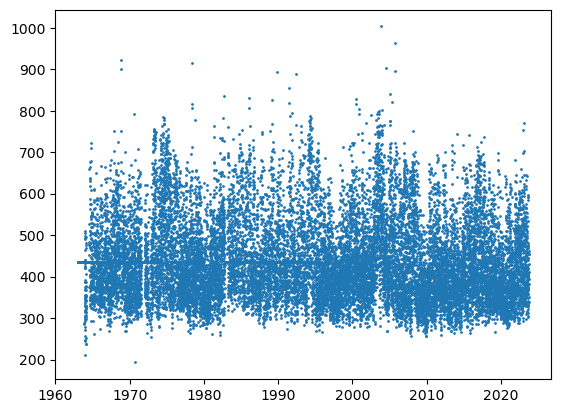

In [35]:
plt.scatter(auger_solar_parameter['date'],auger_solar_parameter['solarw'],s=1)

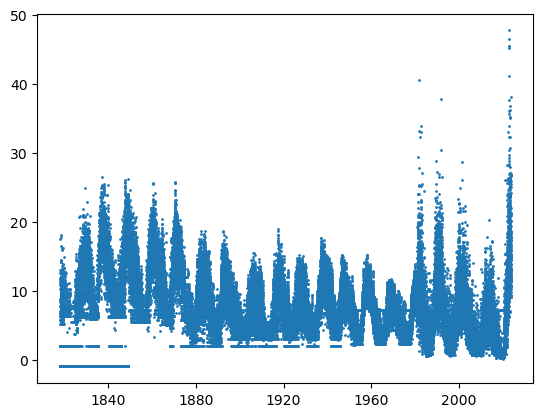

In [36]:
plt.scatter(auger_solar_parameter['date'],auger_solar_parameter['sunspots'],s=1)

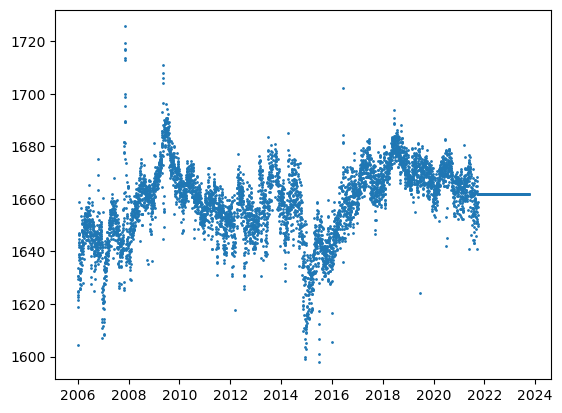

In [47]:
plt.scatter(auger_solar_parameter['date'],auger_solar_parameter['CRI'],s=1)

# Datos de Forbush Decreases by  IZMIRAN

In [ ]:
import requests
import pandas as pd
from io import StringIO

# Crear una lista para almacenar los DataFrames de cada año
dataframes = []

# Rango de años desde 1957 hasta 2021
for year in range(1957, 2022):
    # Construir la URL con el año actual
    url = f"http://spaceweather.izmiran.ru/dbs/fds/years/{year}.txt"
    
    # Realizar una solicitud GET a la URL
    response = requests.get(url)
    
    # Verificar si la solicitud fue exitosa
    if response.status_code == 200:
        # Leer el contenido de la página como una cadena y separar las líneas
        content = response.text
        lines = content.split('\n')
        
        # Crear un DataFrame a partir de las líneas con tabulaciones como separadores
        df = pd.read_csv(StringIO(content), sep='\t', header=None)
        
        # Agregar el DataFrame a la lista
        dataframes.append(df)

# Concatenar todos los DataFrames en uno solo
df_combined = pd.concat(dataframes)

# Restablecer el índice del DataFrame resultante
#df_combined.reset_index(drop=True, inplace=True)
# Ahora df_combined contiene los datos de todos los años en un solo DataFrame de pandas
df_combined

In [ ]:
df_combined.to_csv("forbush_decrease_ALL_years.csv")